In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d, median_filter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


In [2]:
# Paths
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")
TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

CONFIG = {
    'image_size': (128, 128),
    'batch_size': 64,
    'num_epochs': 25,
    'learning_rate': 2e-4,
    'patience': 5,
    
    # Latent dimensions to try
    'latent_dims': [64, 128],
    
    # Seeds for ensemble
    'seeds': [42, 123, 456, 789],
}

print("Config ready")

Config ready


In [3]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)
print(f"Train: {sum(len(v) for v in train_frames.values())} frames")
print(f"Test: {sum(len(v) for v in test_frames.values())} frames")

Train: 9204 frames
Test: 11706 frames


In [4]:
test_frame_ids = []
test_frame_info = []
for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))
print(f"Test IDs: {len(test_frame_ids)}")

# Build video fnums lookup
test_video_fnums = defaultdict(list)
for vid, fnum in test_frame_info:
    test_video_fnums[vid].append(fnum)
for vid in test_video_fnums:
    test_video_fnums[vid] = sorted(set(test_video_fnums[vid]))

Test IDs: 11706


In [5]:
def load_to_gpu(frames_dict, image_size, device):
    total = sum(len(v) for v in frames_dict.values())
    H, W = image_size
    tensors = torch.zeros(total, 3, H, W, dtype=torch.float32, device=device)
    info = []
    idx = 0
    pbar = tqdm(total=total, desc="Loading")
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            img = Image.open(path).convert('RGB').resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32) / 127.5 - 1.0
            tensors[idx] = torch.from_numpy(arr).permute(2, 0, 1)
            info.append((vid, fnum))
            idx += 1
            pbar.update(1)
    pbar.close()
    return tensors, info

print("Loading data to GPU...")
train_tensors, train_info = load_to_gpu(train_frames, CONFIG['image_size'], DEVICE)
test_tensors, test_info = load_to_gpu(test_frames, CONFIG['image_size'], DEVICE)
print(f"GPU: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading data to GPU...


Loading:   0%|          | 0/9204 [00:00<?, ?it/s]

Loading:   0%|          | 0/11706 [00:00<?, ?it/s]

GPU: 4.11 GB


In [6]:
class SimpleAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True),
        )
        self.fc_enc = nn.Sequential(nn.Flatten(), nn.Linear(512*4*4, latent_dim))
        self.fc_dec = nn.Sequential(nn.Linear(latent_dim, 512*4*4), nn.LeakyReLU(0.2, True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.fc_enc(self.encoder(x))
        return self.decoder(self.fc_dec(z).view(-1, 512, 4, 4))

In [7]:
def train_model(seed, latent_dim, train_tensors, config, device):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    model = SimpleAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    
    loader = DataLoader(TensorDataset(train_tensors), batch_size=config['batch_size'], shuffle=True)
    
    best_loss = float('inf')
    patience = 0
    best_state = None
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        for (batch,) in loader:
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(batch), batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        if avg_loss < best_loss - 1e-5:
            best_loss = avg_loss
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1
        
        if patience >= config['patience']:
            break
    
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_loss

In [8]:
print("=" * 60)
print("TRAINING MODELS")
print("=" * 60)

# Train models for each latent dim
models_by_latent = {}

for latent_dim in CONFIG['latent_dims']:
    print(f"\n--- Latent dim: {latent_dim} ---")
    models_by_latent[latent_dim] = []
    
    for seed in CONFIG['seeds']:
        print(f"  Seed {seed}...", end=" ")
        model, loss = train_model(seed, latent_dim, train_tensors, CONFIG, DEVICE)
        models_by_latent[latent_dim].append(model)
        print(f"loss={loss:.5f}")

print(f"\nTrained {sum(len(m) for m in models_by_latent.values())} models total")

TRAINING MODELS

--- Latent dim: 64 ---
  Seed 42... loss=0.00224
  Seed 123... loss=0.00235
  Seed 456... loss=0.00234
  Seed 789... loss=0.00234

--- Latent dim: 128 ---
  Seed 42... loss=0.00212
  Seed 123... loss=0.00214
  Seed 456... loss=0.00220
  Seed 789... loss=0.00222

Trained 8 models total


In [9]:
@torch.no_grad()
def get_max_scores(model, tensors, frame_info, batch_size=128):
    model.eval()
    scores = {}
    for start in range(0, len(tensors), batch_size):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        max_err = torch.amax((batch - recon) ** 2, dim=(1, 2, 3))
        for i, s in enumerate(max_err.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(s)
    return scores

def normalize(scores, clip_pct=99):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    clip_val = np.percentile(vals, clip_pct)
    vals = np.clip(vals, 0, clip_val)
    v_min, v_max = vals.min(), vals.max()
    if v_max > v_min:
        norm = (vals - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals) * 0.5
    return {k: float(norm[i]) for i, k in enumerate(keys)}

def ensemble_mean(score_list):
    keys = list(score_list[0].keys())
    return {k: np.mean([s[k] for s in score_list]) for k in keys}

In [10]:
print("Computing scores...")

scores_by_latent = {}

for latent_dim, models in models_by_latent.items():
    print(f"\nLatent {latent_dim}:")
    all_scores = []
    for i, model in enumerate(models):
        print(f"  Model {i+1}...", end=" ")
        scores = get_max_scores(model, test_tensors, test_info)
        all_scores.append(normalize(scores))
        print("done")
    
    # Ensemble
    ensemble = normalize(ensemble_mean(all_scores), clip_pct=100)
    scores_by_latent[latent_dim] = ensemble
    print(f"  Ensemble created")

# Also create combined ensemble (64 + 128)
all_norm_scores = []
for latent_dim, models in models_by_latent.items():
    for model in models:
        scores = get_max_scores(model, test_tensors, test_info)
        all_norm_scores.append(normalize(scores))

combined_ensemble = normalize(ensemble_mean(all_norm_scores), clip_pct=100)
scores_by_latent['combined'] = combined_ensemble
print(f"\nCombined ensemble (64+128) created")

Computing scores...

Latent 64:
  Model 1... done
  Model 2... done
  Model 3... done
  Model 4... done
  Ensemble created

Latent 128:
  Model 1... done
  Model 2... done
  Model 3... done
  Model 4... done
  Ensemble created

Combined ensemble (64+128) created


In [11]:
def gaussian_smooth(scores, test_frames, video_fnums, sigma):
    """Gaussian smoothing within each video."""
    if sigma == 0:
        return scores.copy()
    
    smoothed = {}
    for vid in sorted(test_frames.keys()):
        fnums = video_fnums[vid]
        vals = np.array([scores.get(f"{vid}_{fn}", 0) for fn in fnums])
        
        if len(vals) > 1:
            vals_smooth = gaussian_filter1d(vals, sigma=sigma)
        else:
            vals_smooth = vals
        
        for i, fn in enumerate(fnums):
            smoothed[f"{vid}_{fn}"] = float(vals_smooth[i])
    
    return smoothed

def median_smooth(scores, test_frames, video_fnums, window_size):
    """Median filter smoothing within each video."""
    if window_size <= 1:
        return scores.copy()
    
    smoothed = {}
    for vid in sorted(test_frames.keys()):
        fnums = video_fnums[vid]
        vals = np.array([scores.get(f"{vid}_{fn}", 0) for fn in fnums])
        
        if len(vals) > window_size:
            vals_smooth = median_filter(vals, size=window_size)
        else:
            vals_smooth = vals
        
        for i, fn in enumerate(fnums):
            smoothed[f"{vid}_{fn}"] = float(vals_smooth[i])
    
    return smoothed

def ema_smooth(scores, test_frames, video_fnums, alpha):
    """Exponential Moving Average smoothing (bidirectional)."""
    smoothed = {}
    
    for vid in sorted(test_frames.keys()):
        fnums = video_fnums[vid]
        vals = np.array([scores.get(f"{vid}_{fn}", 0) for fn in fnums])
        
        if len(vals) > 1:
            # Forward EMA
            fwd = np.zeros_like(vals)
            fwd[0] = vals[0]
            for i in range(1, len(vals)):
                fwd[i] = alpha * vals[i] + (1 - alpha) * fwd[i-1]
            
            # Backward EMA
            bwd = np.zeros_like(vals)
            bwd[-1] = vals[-1]
            for i in range(len(vals) - 2, -1, -1):
                bwd[i] = alpha * vals[i] + (1 - alpha) * bwd[i+1]
            
            # Average forward and backward
            vals_smooth = (fwd + bwd) / 2
        else:
            vals_smooth = vals
        
        for i, fn in enumerate(fnums):
            smoothed[f"{vid}_{fn}"] = float(vals_smooth[i])
    
    return smoothed

def savgol_smooth(scores, test_frames, video_fnums, window_size, poly_order=2):
    """Savitzky-Golay filter smoothing."""
    from scipy.signal import savgol_filter
    
    smoothed = {}
    for vid in sorted(test_frames.keys()):
        fnums = video_fnums[vid]
        vals = np.array([scores.get(f"{vid}_{fn}", 0) for fn in fnums])
        
        if len(vals) > window_size:
            vals_smooth = savgol_filter(vals, window_size, poly_order)
        else:
            vals_smooth = vals
        
        for i, fn in enumerate(fnums):
            smoothed[f"{vid}_{fn}"] = float(vals_smooth[i])
    
    return smoothed

print("Smoothing functions defined")

Smoothing functions defined


In [12]:
submissions = {}

# Use combined ensemble as base (best performing)
base_scores = scores_by_latent['combined']

print("Generating smoothing variations...")
print("-" * 50)

# 1. Gaussian smoothing with various sigma values
for sigma in [3, 4, 5, 6, 7, 8]:
    name = f'gauss_s{sigma}'
    smoothed = gaussian_smooth(base_scores, test_frames, test_video_fnums, sigma)
    submissions[name] = normalize(smoothed, clip_pct=100)
    print(f"Created: {name}")

# 2. Median filter with various window sizes
for window in [3, 5, 7, 9, 11]:
    name = f'median_w{window}'
    smoothed = median_smooth(base_scores, test_frames, test_video_fnums, window)
    submissions[name] = normalize(smoothed, clip_pct=100)
    print(f"Created: {name}")

# 3. Exponential Moving Average with various alpha
for alpha in [0.2, 0.3, 0.4, 0.5]:
    name = f'ema_a{int(alpha*10)}'
    smoothed = ema_smooth(base_scores, test_frames, test_video_fnums, alpha)
    submissions[name] = normalize(smoothed, clip_pct=100)
    print(f"Created: {name}")

# 4. Savitzky-Golay filter
for window in [7, 11, 15]:
    name = f'savgol_w{window}'
    smoothed = savgol_smooth(base_scores, test_frames, test_video_fnums, window)
    submissions[name] = normalize(smoothed, clip_pct=100)
    print(f"Created: {name}")

print("-" * 50)
print(f"Total: {len(submissions)} submissions")

Generating smoothing variations...
--------------------------------------------------
Created: gauss_s3
Created: gauss_s4
Created: gauss_s5
Created: gauss_s6
Created: gauss_s7
Created: gauss_s8
Created: median_w3
Created: median_w5
Created: median_w7
Created: median_w9
Created: median_w11
Created: ema_a2
Created: ema_a3
Created: ema_a4
Created: ema_a5
Created: savgol_w7
Created: savgol_w11
Created: savgol_w15
--------------------------------------------------
Total: 18 submissions


In [13]:
# Also try smoothing on latent64 only (tight bottleneck)
print("\nLatent64 + smoothing variations...")

latent64_base = scores_by_latent[64]

for sigma in [3, 4, 5]:
    name = f'lat64_gauss_s{sigma}'
    smoothed = gaussian_smooth(latent64_base, test_frames, test_video_fnums, sigma)
    submissions[name] = normalize(smoothed, clip_pct=100)
    print(f"Created: {name}")

print(f"\nTotal submissions: {len(submissions)}")


Latent64 + smoothing variations...
Created: lat64_gauss_s3
Created: lat64_gauss_s4
Created: lat64_gauss_s5

Total submissions: 21


In [14]:
def save_sub(scores, filename):
    df = pd.DataFrame([{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in test_frame_ids])
    df.to_csv(os.path.join(OUTPUT_DIR, filename), index=False)
    print(f"Saved: {filename}")
    return df

print("Saving submissions...")
print("=" * 50)

for name, scores in submissions.items():
    save_sub(scores, f'sub_{name}.csv')

print("=" * 50)
print(f"Saved {len(submissions)} submissions")

Saving submissions...
Saved: sub_gauss_s3.csv
Saved: sub_gauss_s4.csv
Saved: sub_gauss_s5.csv
Saved: sub_gauss_s6.csv
Saved: sub_gauss_s7.csv
Saved: sub_gauss_s8.csv
Saved: sub_median_w3.csv
Saved: sub_median_w5.csv
Saved: sub_median_w7.csv
Saved: sub_median_w9.csv
Saved: sub_median_w11.csv
Saved: sub_ema_a2.csv
Saved: sub_ema_a3.csv
Saved: sub_ema_a4.csv
Saved: sub_ema_a5.csv
Saved: sub_savgol_w7.csv
Saved: sub_savgol_w11.csv
Saved: sub_savgol_w15.csv
Saved: sub_lat64_gauss_s3.csv
Saved: sub_lat64_gauss_s4.csv
Saved: sub_lat64_gauss_s5.csv
Saved 21 submissions


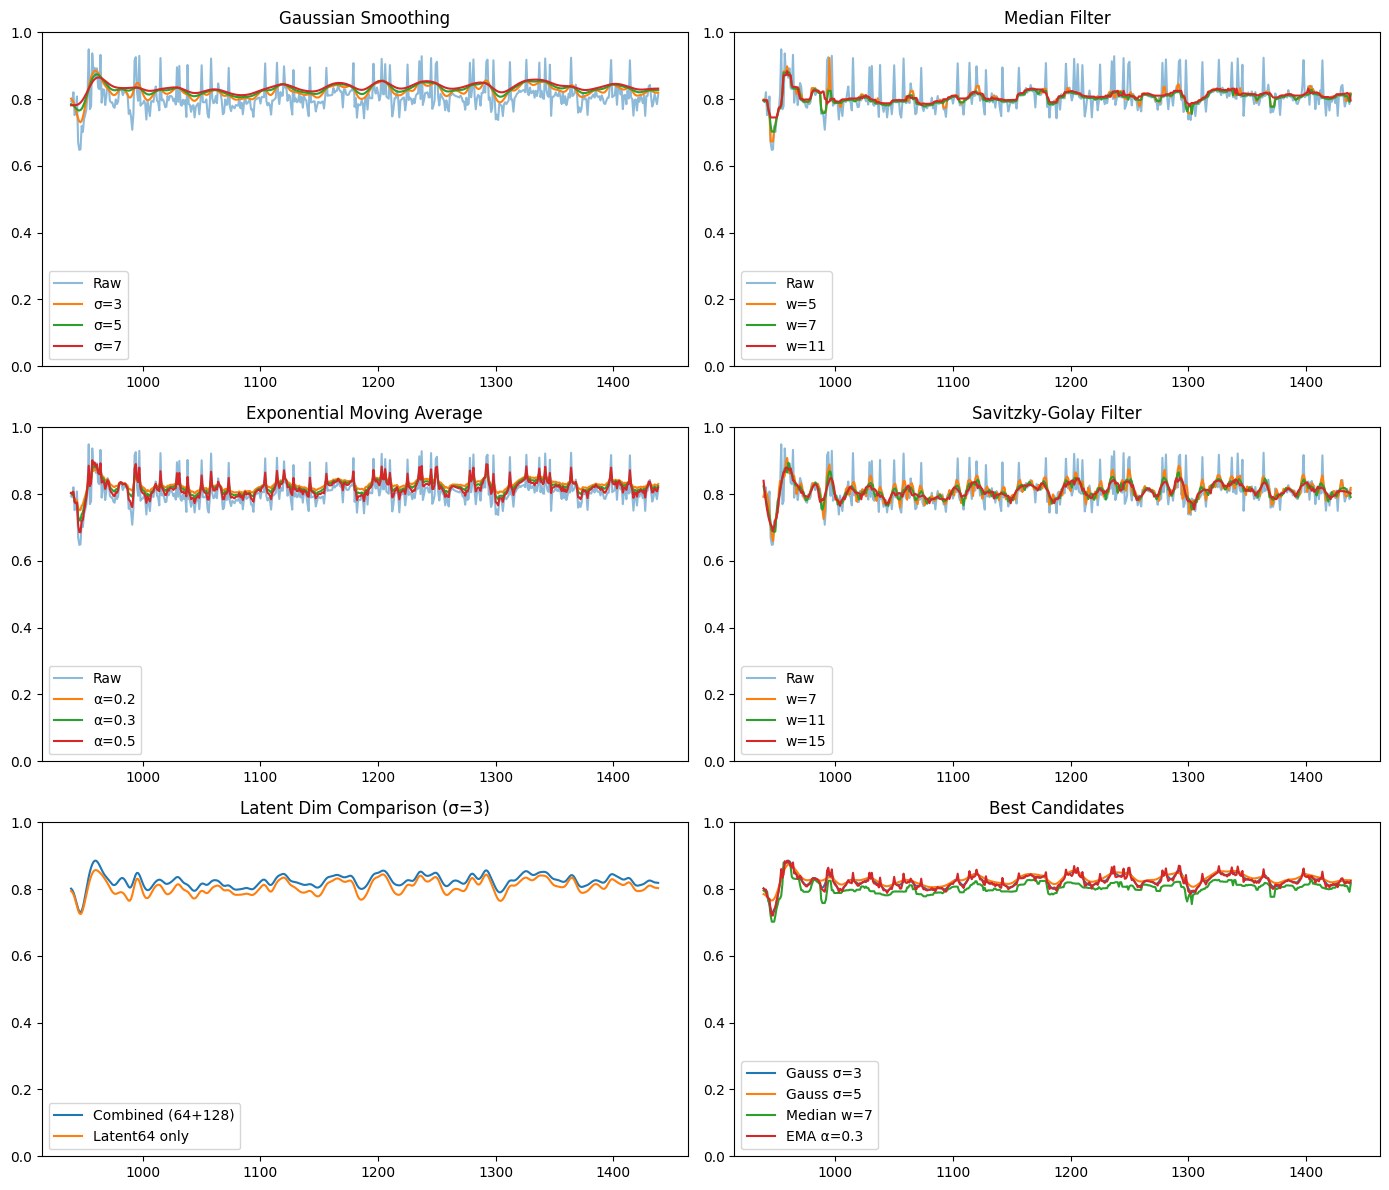

In [15]:
# Compare different smoothing methods on a sample video
sample_vid = sorted(test_frames.keys())[0]
fnums = test_video_fnums[sample_vid]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Raw vs Gaussian
ax = axes[0, 0]
raw = [base_scores.get(f"{sample_vid}_{fn}", 0) for fn in fnums]
ax.plot(fnums, raw, alpha=0.5, label='Raw')
for sigma in [3, 5, 7]:
    smoothed = [submissions[f'gauss_s{sigma}'].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
    ax.plot(fnums, smoothed, label=f'σ={sigma}')
ax.set_title('Gaussian Smoothing')
ax.legend()
ax.set_ylim(0, 1)

# Median filter
ax = axes[0, 1]
ax.plot(fnums, raw, alpha=0.5, label='Raw')
for window in [5, 7, 11]:
    smoothed = [submissions[f'median_w{window}'].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
    ax.plot(fnums, smoothed, label=f'w={window}')
ax.set_title('Median Filter')
ax.legend()
ax.set_ylim(0, 1)

# EMA
ax = axes[1, 0]
ax.plot(fnums, raw, alpha=0.5, label='Raw')
for alpha in [0.2, 0.3, 0.5]:
    smoothed = [submissions[f'ema_a{int(alpha*10)}'].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
    ax.plot(fnums, smoothed, label=f'α={alpha}')
ax.set_title('Exponential Moving Average')
ax.legend()
ax.set_ylim(0, 1)

# Savitzky-Golay
ax = axes[1, 1]
ax.plot(fnums, raw, alpha=0.5, label='Raw')
for window in [7, 11, 15]:
    smoothed = [submissions[f'savgol_w{window}'].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
    ax.plot(fnums, smoothed, label=f'w={window}')
ax.set_title('Savitzky-Golay Filter')
ax.legend()
ax.set_ylim(0, 1)

# Latent64 vs Combined
ax = axes[2, 0]
combined_s3 = [submissions['gauss_s3'].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
lat64_s3 = [submissions['lat64_gauss_s3'].get(f"{sample_vid}_{fn}", 0) for fn in fnums]
ax.plot(fnums, combined_s3, label='Combined (64+128)')
ax.plot(fnums, lat64_s3, label='Latent64 only')
ax.set_title('Latent Dim Comparison (σ=3)')
ax.legend()
ax.set_ylim(0, 1)

# Best candidates comparison
ax = axes[2, 1]
ax.plot(fnums, [submissions['gauss_s3'].get(f"{sample_vid}_{fn}", 0) for fn in fnums], label='Gauss σ=3')
ax.plot(fnums, [submissions['gauss_s5'].get(f"{sample_vid}_{fn}", 0) for fn in fnums], label='Gauss σ=5')
ax.plot(fnums, [submissions['median_w7'].get(f"{sample_vid}_{fn}", 0) for fn in fnums], label='Median w=7')
ax.plot(fnums, [submissions['ema_a3'].get(f"{sample_vid}_{fn}", 0) for fn in fnums], label='EMA α=0.3')
ax.set_title('Best Candidates')
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'smoothing_comparison.png'))
plt.show()

In [16]:
# Cleanup
del train_tensors, test_tensors, models_by_latent
gc.collect()
torch.cuda.empty_cache()
print("Done!")

Done!
